In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from scipy.optimize import minimize_scalar
from sklearn.metrics import mean_squared_error
import time
import matplotlib.pyplot as plt

In [0]:
class RandomForestMSE:
    def __init__(self, n_estimators, max_depth=None, feature_subsample_size=None, 
                 random_seed=75, **trees_parameters):
        """
        n_estimators : int
            The number of trees in the forest.
        
        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        
        feature_subsample_size : float
            The size of feature set for each tree. If None then use recommendations.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        self.trees_params = trees_parameters
        self.random_seed=random_seed
        
    def fit(self, X, y):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
            
        y : numpy ndarray
            Array of size n_objects
        """
        np.random.seed(self.random_seed)
        self.trees_list = []
        self.ind_list = []
        if(self.feature_subsample_size is None):
            self.feature_subsample_size = np.size(X, 1) // 3  # regression task
        for i in range(self.n_estimators):
            ind = np.random.randint(np.size(X, 1), 
                                    size=self.feature_subsample_size)
            self.ind_list.append(ind)
            tree = DecisionTreeRegressor(max_depth=self.max_depth, 
                                         **self.trees_params)
            tree.fit(X[:, ind], y)
            self.trees_list.append(tree)
        
    def predict(self, X, y_val):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
            
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        self.acc_list = []
        sum = 0
        num = 0
        for tree in self.trees_list:
            sum += tree.predict(X[:, self.ind_list[num]])
            num += 1
            curr_pred = sum / num
            self.acc_list.append(np.sqrt(mean_squared_error(y_val, curr_pred)))
        return sum / self.n_estimators
    

class GradientBoostingMSE:
    def __init__(self, n_estimators, learning_rate=0.1, max_depth=5, 
                 feature_subsample_size=None, random_seed=75, **trees_parameters):
        """
        n_estimators : int
            The number of trees in the forest.
        
        learning_rate : float
            Use learning_rate * gamma instead of gamma

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        
        feature_subsample_size : float
            The size of feature set for each tree. If None then use recommendations.
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        self.trees_params = trees_parameters
        self.random_seed = random_seed
        
    def fit(self, X, y):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
            
        y : numpy ndarray
            Array of size n_objects
        """
        np.random.seed(self.random_seed)
        self.trees_list = []
        self.ind_list = []
        self.coeff_list = []
        curr_func = np.zeros(np.shape(y))
        if(self.feature_subsample_size is None):
            self.feature_subsample_size = np.size(X, 1) // 3  # regression task
        for i in range(self.n_estimators):
            ind = np.random.randint(np.size(X, 1), 
                                    size=self.feature_subsample_size)
            self.ind_list.append(ind)
            targ = - curr_func + y
            tree = DecisionTreeRegressor(max_depth=self.max_depth, 
                                         **self.trees_params)
            tree.fit(X[:, ind], targ)
            pred = tree.predict(X[:, ind])
            c_min = minimize_scalar(lambda c: np.sum((curr_func + c * pred - y) ** 2)).x
            self.trees_list.append(tree)
            self.coeff_list.append(self.learning_rate * c_min)
            curr_func += self.learning_rate * c_min * tree.predict(X[:, ind])
            
    def predict(self, X, y_val):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
            
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        self.acc_list = []
        pred_list = []
        num = 0
        for tree in self.trees_list:
            pred_list.append(tree.predict(X[:, self.ind_list[num]]))
            num += 1
            y_pred = np.sum(np.array(self.coeff_list)[:num, np.newaxis] * np.array(pred_list), axis=0)
            self.acc_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        return np.sum(np.array(self.coeff_list)[:, np.newaxis] * np.array(pred_list), axis=0)


In [0]:
with open('/content/gdrive/My Drive/task3/train_data.csv') as data_file:    
    x_train_bold = pd.read_csv(data_file)
with open('/content/gdrive/My Drive/task3/train_target.csv') as data_file:
    y_train_bold = pd.read_csv(data_file)

In [0]:
x_train = x_train_bold.drop(columns=['id', 'index'])
y_train = y_train_bold.drop(columns=['index'])

In [0]:
for i in range(x_train_bold.shape[0]):
    x_train.loc[i, 'month'] = int(str(x_train_bold.loc[i, 'date'])[5:7])

In [0]:
x_train = pd.get_dummies(x_train, columns=['month'])

In [0]:
x_train = x_train.drop(columns=['date'])

In [0]:
x_train = x_train.values
y_train = y_train.values[:, 0]

In [0]:
train_size = (np.size(x_train, 0) // 4) * 3
x_tr = x_train[:train_size]
y_tr = y_train[:train_size]
x_val = x_train[train_size:]
y_val = y_train[train_size:]

number of estimators

In [0]:
mdl = RandomForestMSE(n_estimators=1000)
mdl.fit(x_tr,y_tr)
mdl.predict(x_val, y_val)

array([366.76115935, 377.6261344 , 643.58077443, ..., 297.34999778,
       312.70150168, 534.41123378])

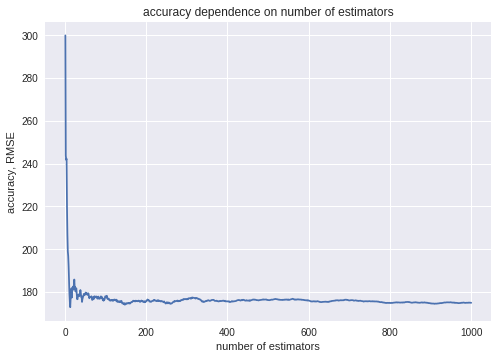

In [143]:
plt.plot(np.arange(1, 1001), mdl.acc_list)
plt.xlabel('number of estimators') 
plt.ylabel('accuracy, RMSE')
plt.title('accuracy dependence on number of estimators')
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/task3/est_acc_1.pdf')

In [0]:
est_list = [10 * x for x in range(1, 11)]
time_list = []

for est in est_list:
    start = time.time()
    model = RandomForestMSE(n_estimators=est)
    model.fit(x_tr, y_tr)
    model.predict(x_val, y_val)
    end = time.time()
    time_list.append(end - start)
    


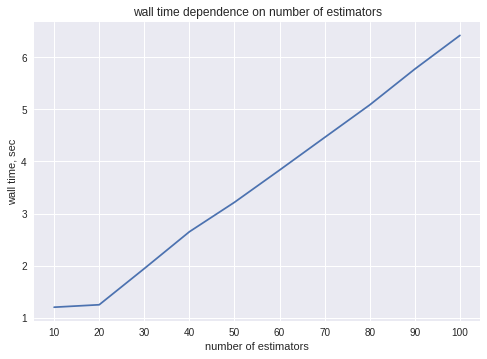

In [150]:
plt.plot(est_list, time_list)
plt.xlabel('number of estimators')
plt.ylabel('wall time, sec')
plt.xticks(est_list)
plt.title('wall time dependence on number of estimators')
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/task3/est_time_1.pdf')

In [0]:
est_list_2 = [x for x in range(1, 25)]
time_list_2 = []

for est in est_list_2:
    start = time.time()
    model = RandomForestMSE(n_estimators=est)
    model.fit(x_tr, y_tr)
    model.predict(x_val, y_val)
    end = time.time()
    time_list_2.append(end - start)

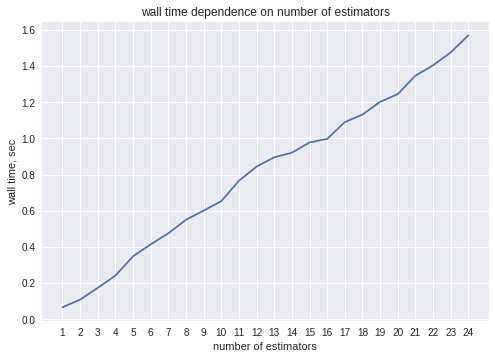

In [157]:
plt.plot(est_list_2, time_list_2)
plt.xlabel('number of estimators')
plt.ylabel('wall time, sec')
plt.xticks(est_list_2)
plt.title('wall time dependence on number of estimators')
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/task3/est_time_2.pdf')

зависимость от размера подвыборки признаков

In [0]:
feat_list_3 = [x for x in range(5, 50, 5)]
acc_list_3 = []
time_list_3 = []

for feat in feat_list_3:
    start = time.time()
    model = RandomForestMSE(n_estimators=200, feature_subsample_size=feat)
    model.fit(x_tr, y_tr)
    y_pred = model.predict(x_val, y_val)
    end = time.time()
    acc_list_3.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    time_list_3.append(end - start)

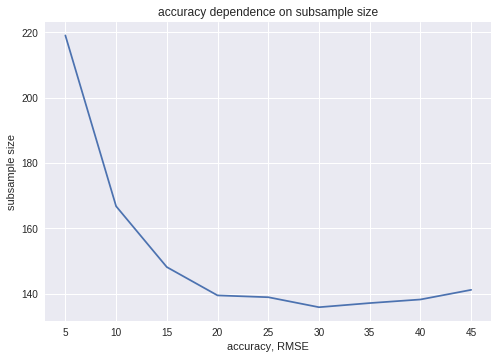

In [163]:
plt.plot(feat_list, acc_list_3)
plt.xlabel('accuracy, RMSE')
plt.ylabel('subsample size')
plt.title('accuracy dependence on subsample size')
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/task3/feat_acc.pdf')


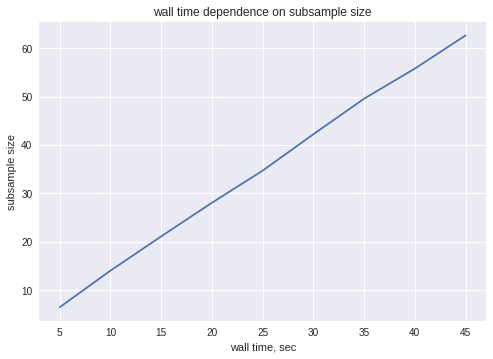

In [164]:
plt.plot(feat_list, time_list_3)
plt.xlabel('wall time, sec')
plt.ylabel('subsample size')
plt.title('wall time dependence on subsample size')
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/task3/feat_time.pdf')

In [0]:
depth_list = [x for x in range(1, 50, 5)]
acc_list_4 = []
time_list_4 = []

for depth in depth_list:
    start = time.time()
    model = RandomForestMSE(n_estimators=200, feature_subsample_size=30, max_depth=depth)
    model.fit(x_tr, y_tr)
    y_pred = model.predict(x_val, y_val)
    end = time.time()
    acc_list_4.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    time_list_4.append(end - start)

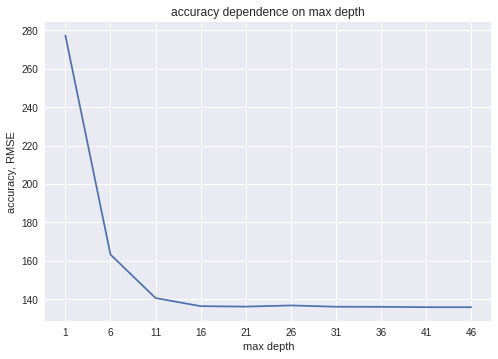

In [173]:
plt.plot(depth_list, acc_list_4)
plt.xlabel('max depth')
plt.ylabel('accuracy, RMSE')
plt.title('accuracy dependence on max depth')
plt.xticks(depth_list)
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/task3/depth_acc_1.pdf')

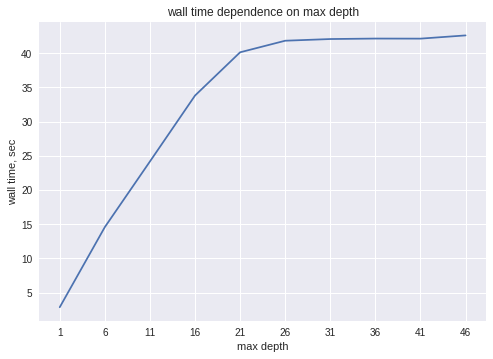

In [174]:
plt.plot(depth_list, time_list_4)
plt.xlabel('max depth')
plt.ylabel('wall time, sec')
plt.title('wall time dependence on max depth')
plt.xticks(depth_list)
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/task3/depth_time_1.pdf')

In [0]:
depth_list = range(1, 15)
acc_list_5 = []
time_list_5 = []

for depth in depth_list:
    start = time.time()
    model = RandomForestMSE(n_estimators=200, feature_subsample_size=30, max_depth=depth)
    model.fit(x_tr, y_tr)
    y_pred = model.predict(x_val, y_val)
    end = time.time()
    acc_list_5.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    time_list_5.append(end - start)

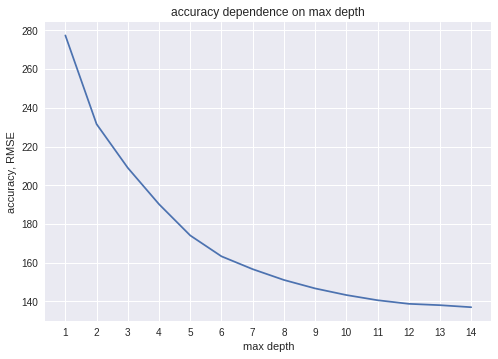

In [176]:
plt.plot(depth_list, acc_list_5)
plt.xlabel('max depth')
plt.ylabel('accuracy, RMSE')
plt.title('accuracy dependence on max depth')
plt.xticks(depth_list)
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/task3/depth_acc_2.pdf')

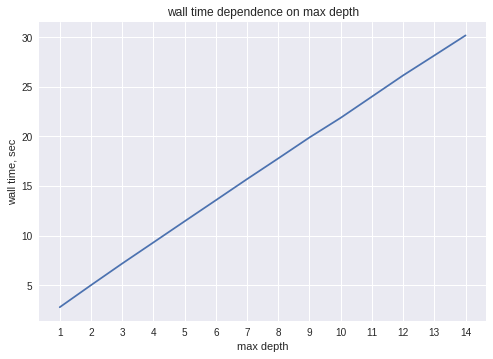

In [178]:
plt.plot(depth_list, time_list_5)
plt.xlabel('max depth')
plt.ylabel('wall time, sec')
plt.title('wall time dependence on max depth')
plt.xticks(depth_list)
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/task3/depth_time_2.pdf')

In [13]:
start = time.time()
model = RandomForestMSE(n_estimators=200, feature_subsample_size=30)
model.fit(x_tr, y_tr)
y_pred = model.predict(x_val, y_val)
end = time.time()
print('time:', end - start)
print('accuracy:', np.sqrt(mean_squared_error(y_val, y_pred)))

time: 42.652031898498535
accuracy: 135.85004781637053


градиентный бустинг

In [62]:
model = GradientBoostingMSE(n_estimators=2000)
model.fit(x_tr, y_tr)
model.predict(x_val, y_val)

array([219.76620147, 334.20097992, 609.03553034, ..., 230.09842743,
       246.10749421, 534.52579264])

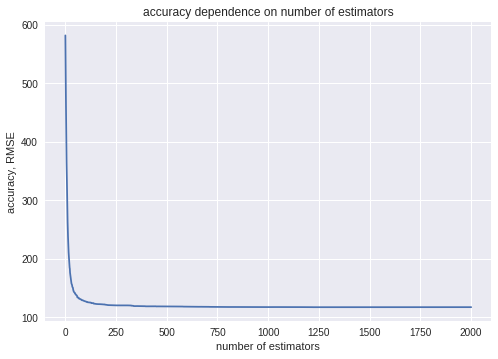

In [63]:
plt.plot(np.arange(1, 2001), model.acc_list)
plt.xlabel('number of estimators')
plt.ylabel('accuracy, RMSE')
plt.title('accuracy dependence on number of estimators')
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/task3/boost_est_acc.pdf')

In [0]:
est_list = [10 * x for x in range(1, 11)]
time_list_6 = []

for est in est_list:
    start = time.time()
    model = GradientBoostingMSE(n_estimators=est)
    model.fit(x_tr, y_tr)
    model.predict(x_val, y_val)
    end = time.time()
    time_list_6.append(end - start)

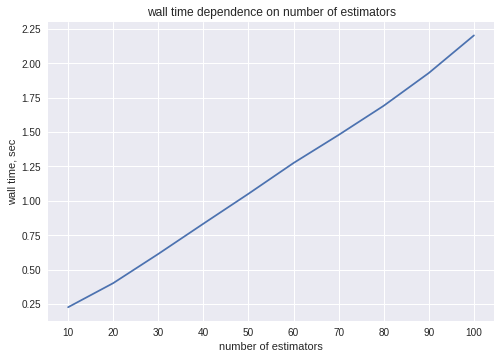

In [59]:
plt.plot(est_list, time_list_6)
plt.xlabel('number of estimators')
plt.ylabel('wall time, sec')
plt.title('wall time dependence on number of estimators')
plt.xticks(est_list)
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/task3/boost_est_time.pdf')

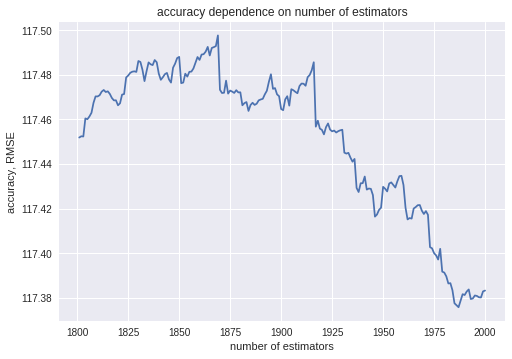

In [68]:
plt.plot(np.arange(1, 201) + 1800, np.array(model.acc_list)[-200:])
plt.xlabel('number of estimators')
plt.ylabel('accuracy, RMSE')
plt.title('accuracy dependence on number of estimators')
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/task3/boost_est_acc_1.pdf')

In [0]:
feat_list = range(5, 35, 5)
time_list_7 = []
acc_list_7 = []

for feat in feat_list:
    start = time.time()
    model = GradientBoostingMSE(n_estimators=1000, feature_subsample_size=feat)
    model.fit(x_tr, y_tr)
    y_pred = model.predict(x_val, y_val)
    end = time.time()
    time_list_7.append(end - start)
    acc_list_7.append(np.sqrt(mean_squared_error(y_val, y_pred)))

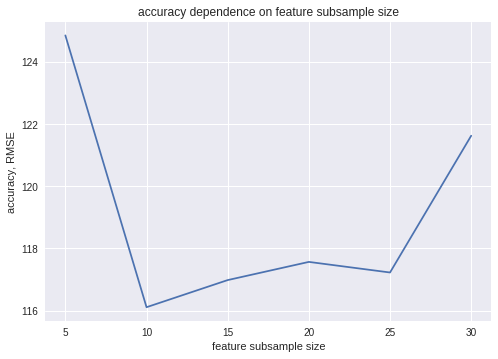

In [71]:
plt.plot(feat_list, acc_list_7)
plt.ylabel('accuracy, RMSE')
plt.xlabel('feature subsample size')
plt.title('accuracy dependence on feature subsample size')
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/task3/boost_feat_acc.pdf')

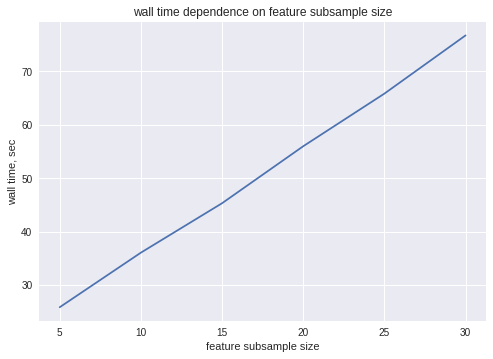

In [72]:
plt.plot(feat_list, time_list_7)
plt.ylabel('wall time, sec')
plt.xlabel('feature subsample size')
plt.title('wall time dependence on feature subsample size')
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/task3/boost_feat_time.pdf')

In [0]:
depth_list = range(1, 10)
acc_list_8 = []
time_list_8 = []

for depth in depth_list:
    start = time.time()
    model = GradientBoostingMSE(n_estimators=1000, feature_subsample_size=10, max_depth=depth)
    model.fit(x_tr, y_tr)
    y_pred = model.predict(x_val, y_val)
    end = time.time()
    acc_list_8.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    time_list_8.append(end - start)

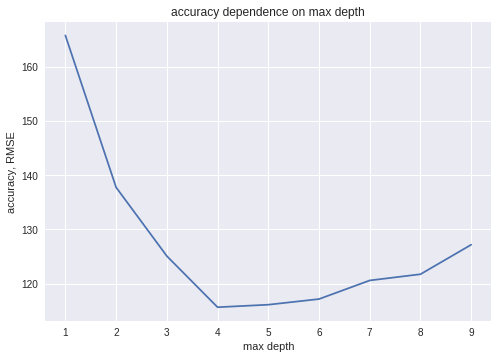

In [74]:
plt.plot(depth_list, acc_list_8)
plt.ylabel('accuracy, RMSE')
plt.xlabel('max depth')
plt.title('accuracy dependence on max depth')
plt.savefig('/content/gdrive/My Drive/task3/boost_depth_acc.pdf')

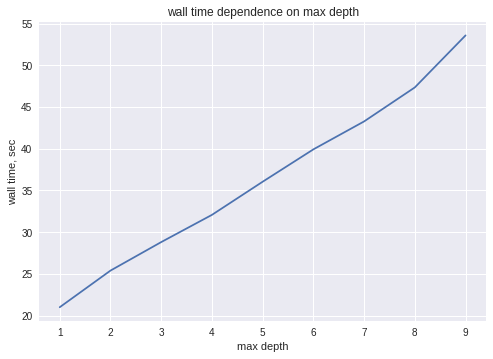

In [75]:
plt.plot(depth_list, time_list_8)
plt.ylabel('wall time, sec')
plt.xlabel('max depth')
plt.title('wall time dependence on max depth')
plt.savefig('/content/gdrive/My Drive/task3/boost_depth_time.pdf')

In [0]:
lr_list = [10 ** i for i in range(-3, 1)]
acc_list_9 = []
time_list_9 = []

for lr in lr_list:
    start = time.time()
    model = GradientBoostingMSE(n_estimators=1000, feature_subsample_size=10, max_depth=4, learning_rate=lr)
    model.fit(x_tr, y_tr)
    y_pred = model.predict(x_val, y_val)
    end = time.time()
    acc_list_9.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    time_list_9.append(end - start)

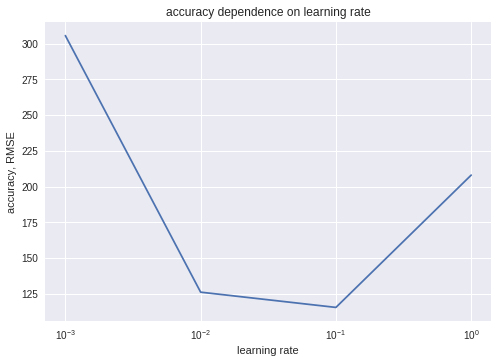

In [101]:
plt.semilogx(lr_list, acc_list_9)
plt.ylabel('accuracy, RMSE')
plt.xlabel('learning rate')
plt.title('accuracy dependence on learning rate')
plt.savefig('/content/gdrive/My Drive/task3/boost_lr_acc.pdf')

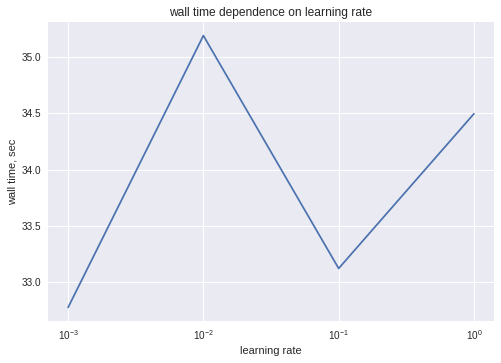

In [102]:
plt.semilogx(lr_list, time_list_9)
plt.ylabel('wall time, sec')
plt.xlabel('learning rate')
plt.title('wall time dependence on learning rate')
plt.savefig('/content/gdrive/My Drive/task3/boost_lr_time.pdf')